In [1]:
import numpy as np
import pandas as pd

from plotnine import ggplot, aes, geom_point
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import sklearn.cluster as cluster

## Introducción

En la mayoría de los problemas de Machine Learning, tenemos acceso a un conjunto de  $p$ variables independiente $X_1, X_2, ..., X_p$, medidas en $n$ observaciones, y una variable dependiente  $Y$ también medida en esas mismas $n$ observaciones. El objetivo es entonces predecir $Y$ usando $X_1, X_2, ..., X_p$. Esto es aprendizaje supervisado. 

En cambio, **el aprendizaje no supervisado es un conjunto de herramientas estadísticas destinadas a los problemas en los que solo tenemos un conjunto de variables independientes $X_1, X_2, ..., X_p$ en $n$ observaciones.** En estos casos, no nos interesa la predicción, porque no tenemos asociada una variable dependiente $Y$. Más bien, **el objetivo es descubrir patrones en las mediciones de las variables $X_1, X_2, ..., X_p$**.

¿Hay alguna forma informativa de visualizar los datos? ¿Es posible reducir la dimensionalidad del conjunto de datos? ¿Podemos descubrir subgrupos entre las variables o entre las observaciones?
El aprendizaje no supervisado puede responder a este tipo de preguntas. 

<image src = "https://raw.githubusercontent.com/sarahiaguilar/fundamentos-cdd/main/viz/supervised_unspervised.PNG">

El aprendizaje no supervisado es a menudo mucho más desafiante por dos principales razones. 

1. **El ejercicio tiende a ser más subjetivo y no existe un objetivo simple para el análisis, como la predicción de una respuesta.** De hecho, el aprendizaje no supervisado a menudo se realiza como parte del análisis exploratorio de datos. 

2. **Los resultados son difíciles de evaluar, ya que no existe un mecanismo universalmente aceptado para predicciones en un conjunto de datos independiente.** La razón de esta diferencia es simple. Si ajustamos un modelo predictivo usando una técnica de aprendizaje supervisado, entonces es posible verificar nuestro trabajo al ver qué tan bien nuestro modelo predice la respuesta $Y$ en las observaciones que no se usaron para ajustar el modelo. Sin embargo, en el aprendizaje no supervisado, no hay forma de verificar nuestro trabajo porque no sabemos la verdadera respuesta: el problema no está supervisado.

## Análisis de componentes principales

<image src = "https://cdn-images-1.medium.com/max/508/1*tkIOCiQIJ9HiO5LWAjUTJg.png">

**El análisis de componentes principales (PCA, por sus siglas en inglés) es una técnica de reducción de dimensionalidad lineal que se puede utilizar para extraer información de un espacio de alta dimensión proyectándola en un subespacio de menor dimensión.** El PCA intenta preservar las partes esenciales que tienen más variación de los datos y eliminar las partes no esenciales con menos variación.

El análisis de componentes principales utiliza una transformación ortogonal para convertir un conjunto de observaciones de variables continuas posiblemente correlacionadas en un conjunto de valores de variables linealmente no correlacionadas llamadas componentes principales.

El análisis de componentes principales tiene dos principales casos de uso: 

* **Visualización de datos**

Para resolver un problema donde los datos son la clave, necesitamos una amplia exploración de estos para descubrir cómo se correlacionan entre sí y comprender sy distribución. Pra ello, la visualización de datos es una herramienta empírica que puede resultar muy útil. Pero,¿qué sucede cuando tenemos más de dos variables? PCA puede proyectar los datos en una dimensión más baja, lo que le permite visualizar los datos en un espacio 2D o 3D a simple vista.

* **Aceleración del entrenamiedo de un modelo de aprendizaje automático**

Dado que el tiempo de entrenamiento de un modelo de aprendizaje automático está en función del tamaño del conjunto de datos (número de observaciones y número de variables) podemos acelerarlo con PCA al reduucir el total de variables. 

**Los componentes principales tienen dirección y magnitud.** La dirección representa a través de qué ejes principales se distribuyen principalmente los datos o tienen la mayor variación, y la magnitud indica la cantidad de variación que el componente principal captura de los datos cuando se proyecta en ese eje. 

**Los componentes principales son una línea recta y el primer componente principal tiene la mayor variación en los datos.** Cada componente principal posterior es ortogonal al último y tiene una varianza menor. De esta forma, dado un conjunto de $p$ variables correlacionadas en $n$ observaciones, se obtiene un conjunto de $u$ componentes principales no correlacionados sobre las mismas $n$ observaciones.

Consideramos un conjunto de datos de dominio público alojado en el [Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)). Este conjunto de datos contiene aproximadamente 570 observaciones extraídas de una base de datos de pacientes del Diagnostic Wisconsin Breast Cancer Database. 

In [2]:
wdbc = load_breast_cancer()

In [3]:
wdbc_data = wdbc.data

wdbc_labels = wdbc.target
wdbc_labels = np.reshape(wdbc_labels, (569,1))

In [4]:
complete_wdbc_data = np.concatenate([wdbc_data, wdbc_labels],axis=1)

In [5]:
wdbc_df = pd.DataFrame(complete_wdbc_data)
wdbc_df.columns = np.append(wdbc.feature_names, "label")
wdbc_df["label"].replace(0, "Benign", inplace=True)
wdbc_df["label"].replace(1, "Malignant", inplace=True)

In [6]:
wdbc_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,label
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,Benign
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,Benign
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,Benign
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,Benign
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,Benign


In [7]:
wdbc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

Dado que los componentes principales se ven influenciados por la escala de las variables, es una práctica común normalizar sus datos antes de aplicar PCA sobre ellos, como con modelos de aprendizaje automático. 

Utilizaremos el transformador de Sickit-Learn `StandardScaler` para distribuir las variables normalmente de modo que escalará la distribución a una media de 0 y una desviación estándar de 1.

In [8]:
# Escala variables indpendientes
X = wdbc_df[wdbc.feature_names]
X = StandardScaler().fit_transform(X)
X = pd.DataFrame(X)

In [9]:
# Crea objeto de PCA
pca = PCA(n_components = 2)

In [10]:
# Aplica PCA
X_pca = pca.fit_transform(X)

In [11]:
# Calcula varianza explicada por cada componente principal
print(pca.explained_variance_ratio_)

[0.44272026 0.18971182]


A partir de la varianza explicada, podemos observar que el componente principal #1 contiene el 44.2% de la información, mientras que el componente principal #2 contiene solo el 18.9% de la información. Esto implica que, al proyectar datos de treinta dimensiones a datos de dos dimensiones, se pierde el 36.8% de la información.

In [12]:
X_pca_df = pd.DataFrame(X_pca)
X_pca_df.columns = ["PC1", "PC2"]
X_pca_df["label"] = wdbc_df.label

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


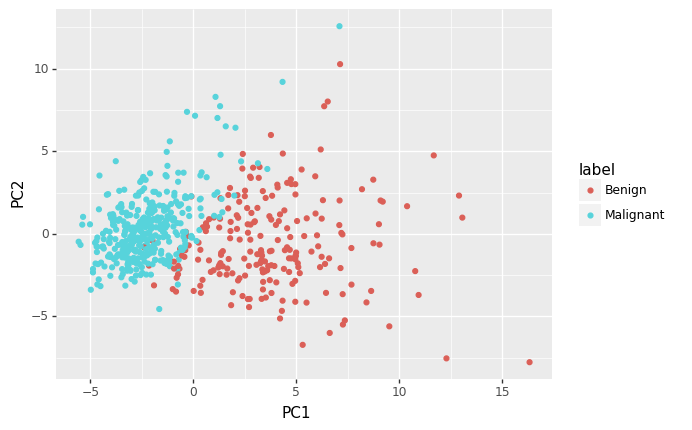

<ggplot: (8757722558277)>

In [13]:
# Grafica componentes principales
ggplot(X_pca_df) + aes(x="PC1", y="PC2", color="label") + geom_point()

## Clustering

El clustering se refiere a un conjunto muy amplio de técnicas para encontrar subgrupos en un conjunto de datos. Cuando agrupamos las observaciones de un conjunto de datos, **buscamos dividirlas en grupos distintos con observaciones dentro de cada grupo sean bastante similares**. Para ello, debemos definir qué significa que dos o más observaciones sean difirentes o similares. 

### K-means

El clustering mediantte K-means es un enfoque simple y elegante para dividir un conjunto de datos en $K$ clústeres distintos que no se superponen. Para realizar el agrupamiento de K-means, primero debemos especificar el número deseado de agrupamientos $K$; entonces el algoritmo de K-medias asignará cada observación exactamente a uno de los $K$ clústerres.

Hay muchas formas posibles de definir este concepto, pero la opción más común es la distancia euclidiana al cuadrado.

Para separar el conjunto de datos en distintos clústeres, necesitamos dividir las observaciones en $K$ clústeres de manera que se minimice la distancia euclideana entre las observaciones de cada uno.Este es un problema muy difícil de resolver con precisión, ya que hay casi $K_n$ formas de dividir $n$ observaciones en $K$ clústeres. Afortunadamente, se puede demostrar que un algoritmo muy simple proporciona un óptimo local.

1. Asignar aleatoriamente un número, del 1 al $K$, a cada una de las observaciones.
Estos sirven como asignaciones de grupos iniciales para las observaciones.

2. Iterar hasta que las asignaciones de clústeres dejen de cambiar: 
  
  a. Para cada uno de los $K$ clústeres, calcular el centroide del cúster. El centroide del clúster es el vector de las medias de las $p$ variables para las observaciones en el clúster.

  b. Asignar cada observación al clúster cuyo centroide sea el más cercano (donde el más cercano se define con la distancia euclidiana).

Consideramos un conjunto de datos de dominio público alojado en [Kaggle](https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python). Este conjunto de datos contiene 200 observaciones extraídas de una base de clientes de Target. 

In [14]:
customers = pd.read_csv("https://raw.githubusercontent.com/sarahiaguilar/fundamentos-cdd/main/datos/customers.csv")

In [15]:
customers.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [16]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [17]:
# Escala variables indpendientes
feature_cols = ["Annual Income (k$)",	"Spending Score (1-100)"]
X = customers[feature_cols]
X = StandardScaler().fit_transform(X)
X = pd.DataFrame(X)

In [18]:
# Crea objeto de K-means
kmeans = cluster.KMeans(n_clusters = 2)

In [19]:
# Aplica K-menas
kmeans.fit(X)
X.columns = ["annual_income", "spending_score"]
X["clusters"] = kmeans.labels_

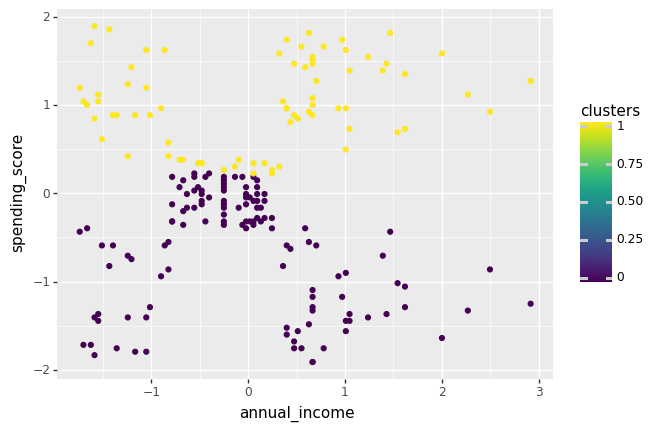

<ggplot: (8757720094061)>

In [20]:
# Grafica clusters
ggplot(X) + aes(x="annual_income", y="spending_score", color="clusters") + geom_point()

**El método del codo es una técnica popular para determinar el número óptimo de clústeres.** En esta técnica, calculamos la suma de errores cuadrados dentro del grupo (en inglés Within Cluster Sum of Squares (WCSS)) para varios valores de $K$ y elegimos la $K$ para la que esta métrica comienza a disminuir. Visualmente, esto se puede observar como un codo.

In [21]:
# Escala variables indpendientes
feature_cols = ["Annual Income (k$)",	"Spending Score (1-100)"]
X = customers[feature_cols]
X = StandardScaler().fit_transform(X)
X = pd.DataFrame(X)

In [22]:
# Itera por cada K y calcula la suma de errores cuadrados dentro del grupo
K = range(2,12)
wss = []

for k in K:
    kmeans = cluster.KMeans(n_clusters=k)
    kmeans = kmeans.fit(X)
    wss_iter = kmeans.inertia_
    wss.append(wss_iter)

Text(0, 0.5, 'Suma de errores cuadrados dentro del grupo')

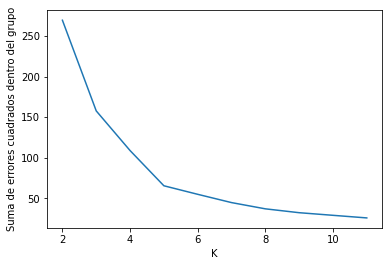

In [23]:
plt.plot(K,wss)
plt.xlabel("K")
plt.ylabel("Suma de errores cuadrados dentro del grupo")